In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
import statsmodels.api as sm
from src.change_point_detection import mmd_statistic, prediction_deviation_analysis
import os
os.chdir('/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection')

   time      value
0  0.00  80.000000
1  0.02  82.676971
2  0.04  82.703523
3  0.06  81.763162
4  0.08  82.514882
initial_value_80_samples_500ws2


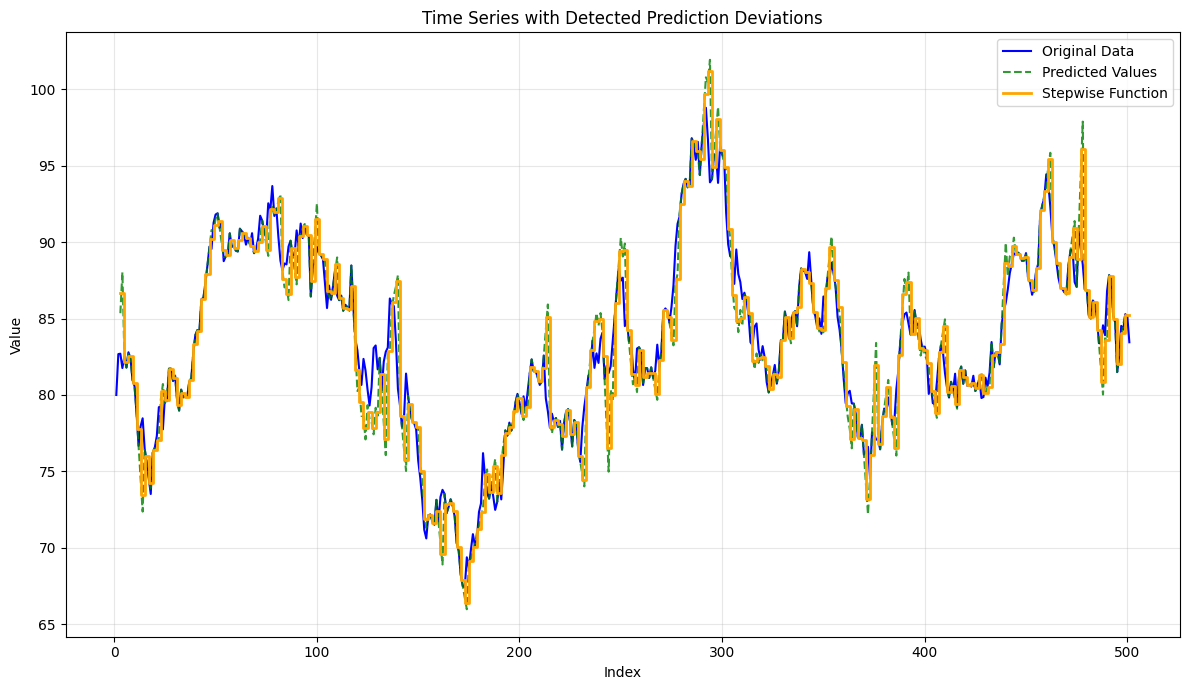

MSE for predicted value 2.9666136199113198
MSE for stepwise value 2.942371824812939
KL divergence 0.9337495751713452
   time      value
0  0.00  80.000000
1  0.02  82.676971
2  0.04  82.703523
3  0.06  81.763162
4  0.08  82.514882
initial_value_80_samples_500ws3


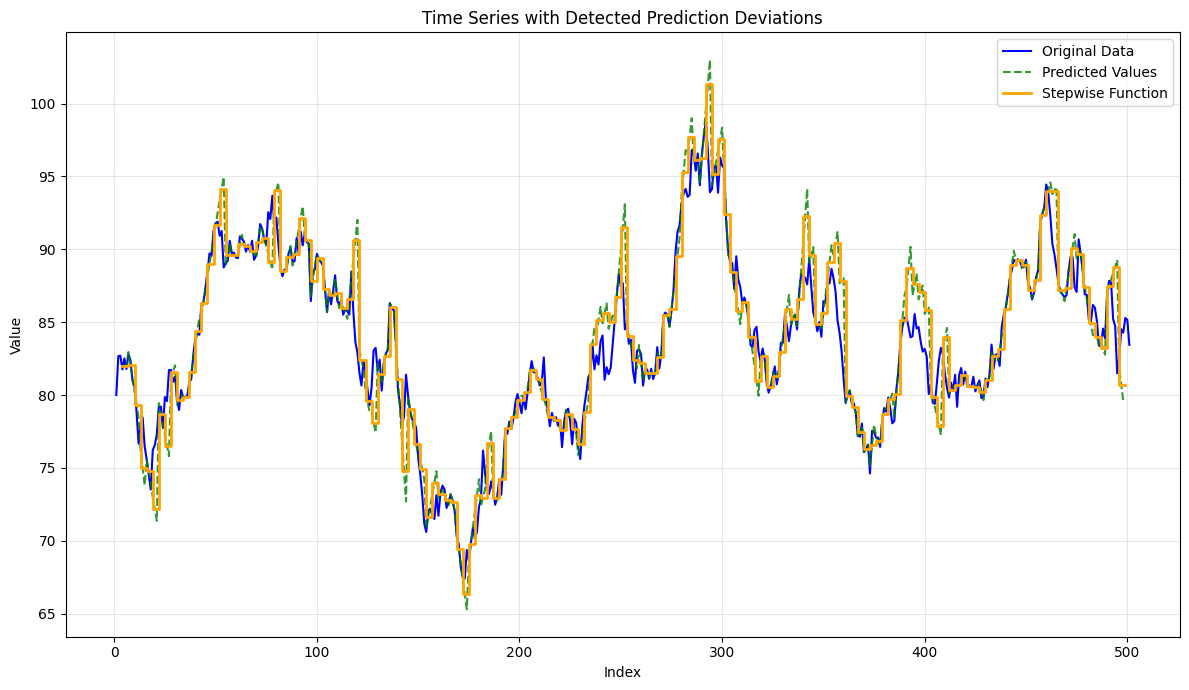

MSE for predicted value 3.7950304065607634
MSE for stepwise value 3.749737603267662
KL divergence 1.3939731734938428
   time      value
0  0.00  80.000000
1  0.02  82.676971
2  0.04  82.703523
3  0.06  81.763162
4  0.08  82.514882
initial_value_80_samples_500ws4


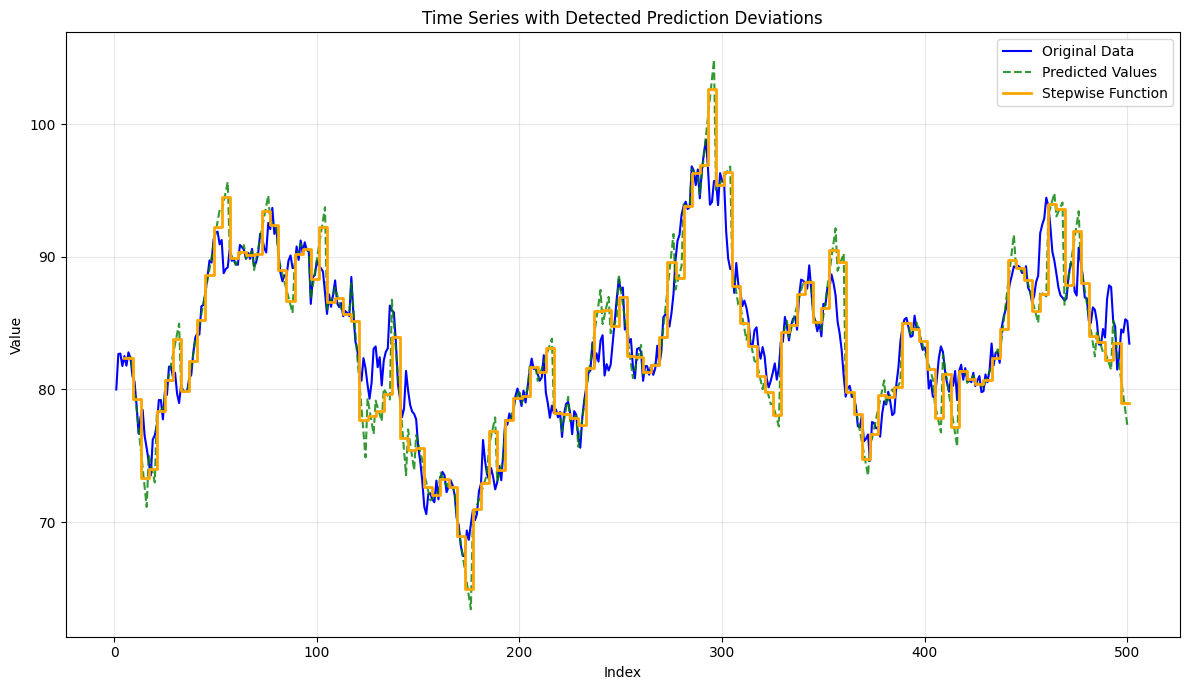

MSE for predicted value 5.725048077797532
MSE for stepwise value 5.68720817978621
KL divergence 2.3355463243615726
   time      value
0  0.00  80.000000
1  0.02  82.676971
2  0.04  82.703523
3  0.06  81.763162
4  0.08  82.514882
initial_value_80_samples_500ws10


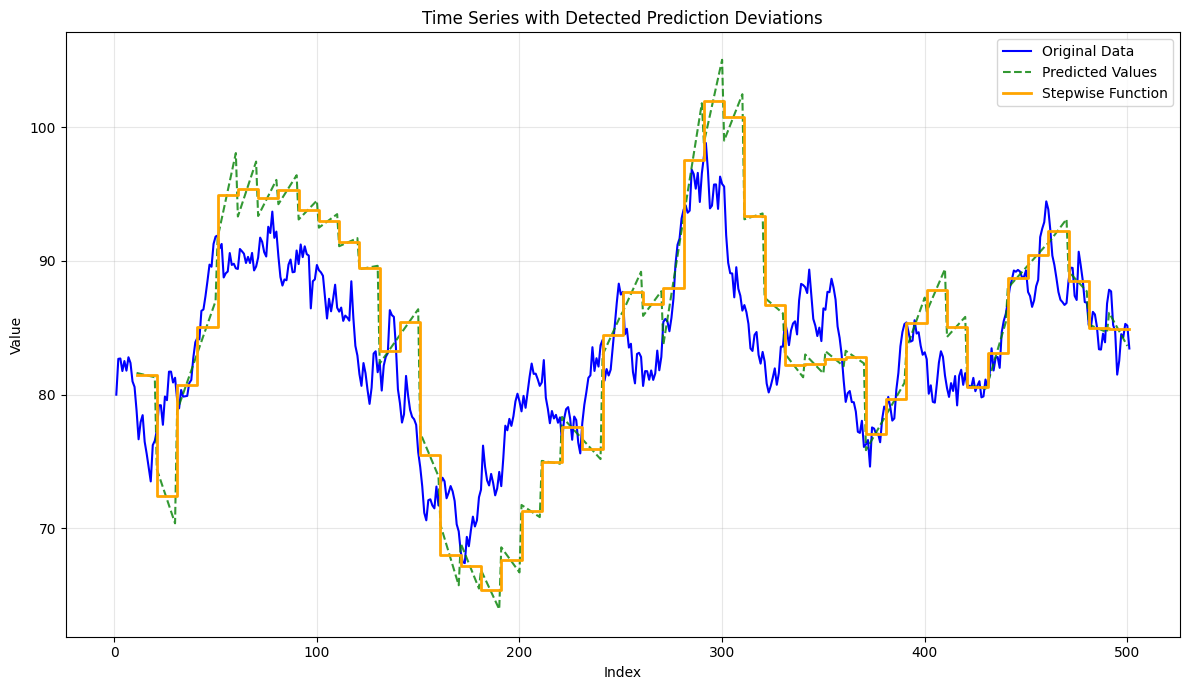

MSE for predicted value 26.87397219169485
MSE for stepwise value 26.412801658671974
KL divergence 2.8709034783493133
   time     value
0  0.00  5.000000
1  0.02  6.070890
2  0.04  6.610556
3  0.06  7.217665
4  0.08  8.034778
initial_value_5_samples_500ws2


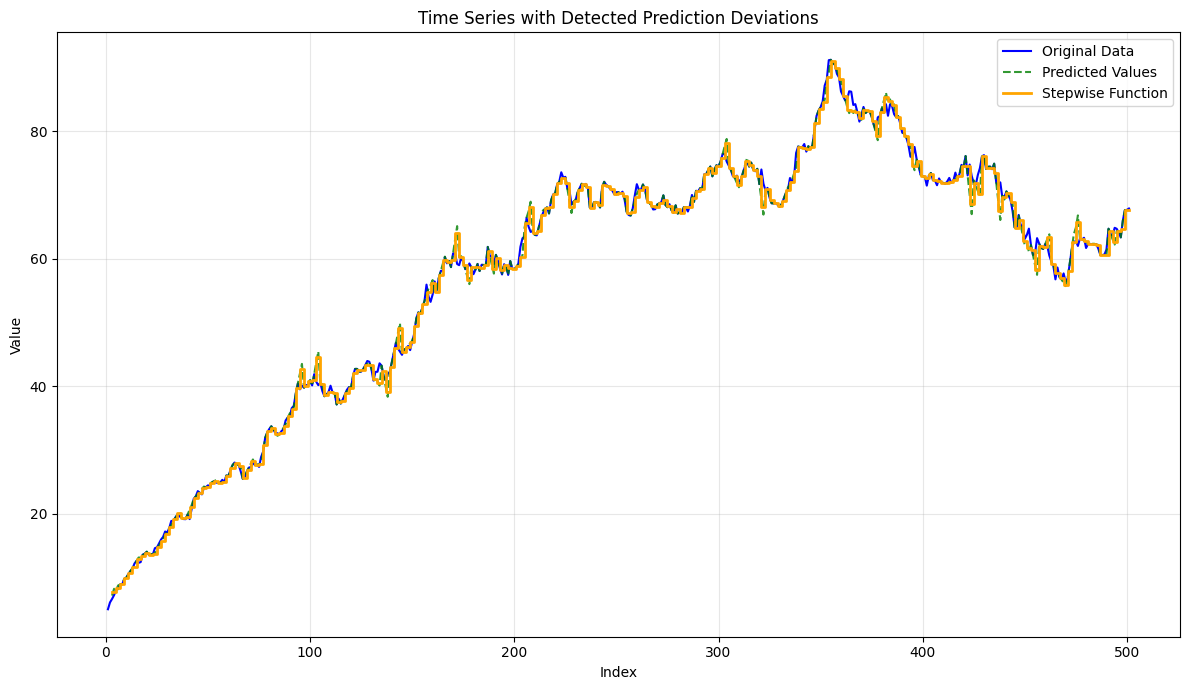

MSE for predicted value 1.314254075834271
MSE for stepwise value 1.4118544505742043
KL divergence 1.0862639227053614
   time     value
0  0.00  5.000000
1  0.02  6.070890
2  0.04  6.610556
3  0.06  7.217665
4  0.08  8.034778
initial_value_5_samples_500ws3


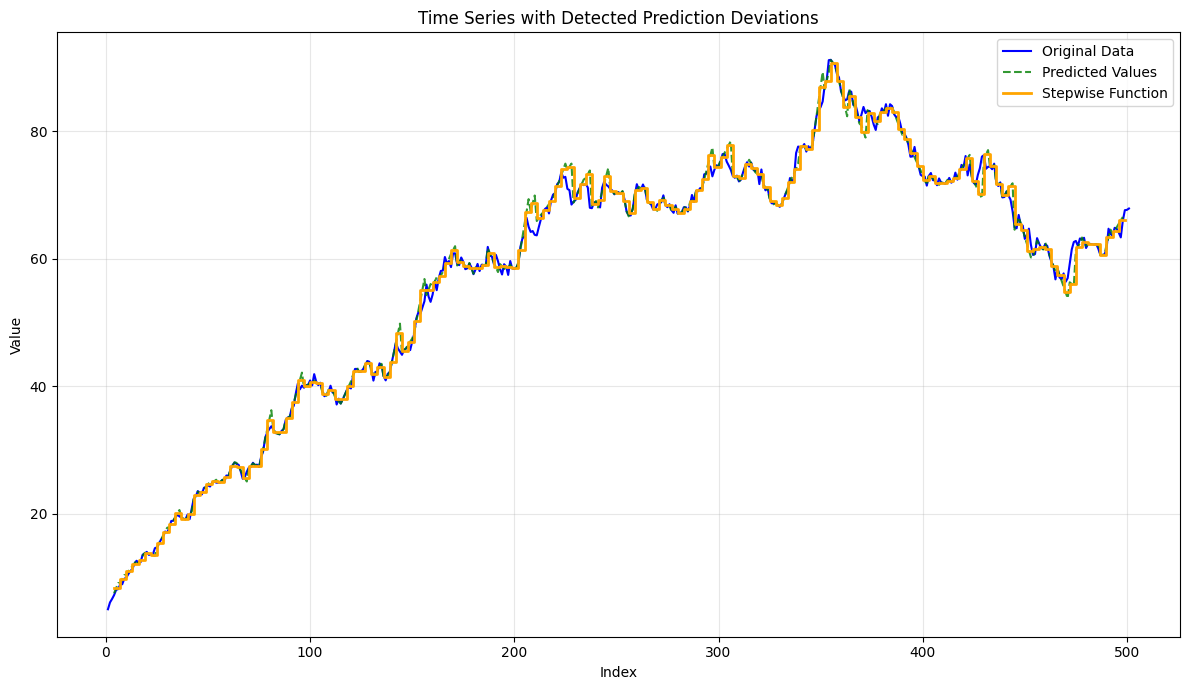

MSE for predicted value 1.600923708743947
MSE for stepwise value 1.7085406554702955
KL divergence 1.8601355614890027
   time     value
0  0.00  5.000000
1  0.02  6.070890
2  0.04  6.610556
3  0.06  7.217665
4  0.08  8.034778
initial_value_5_samples_500ws4


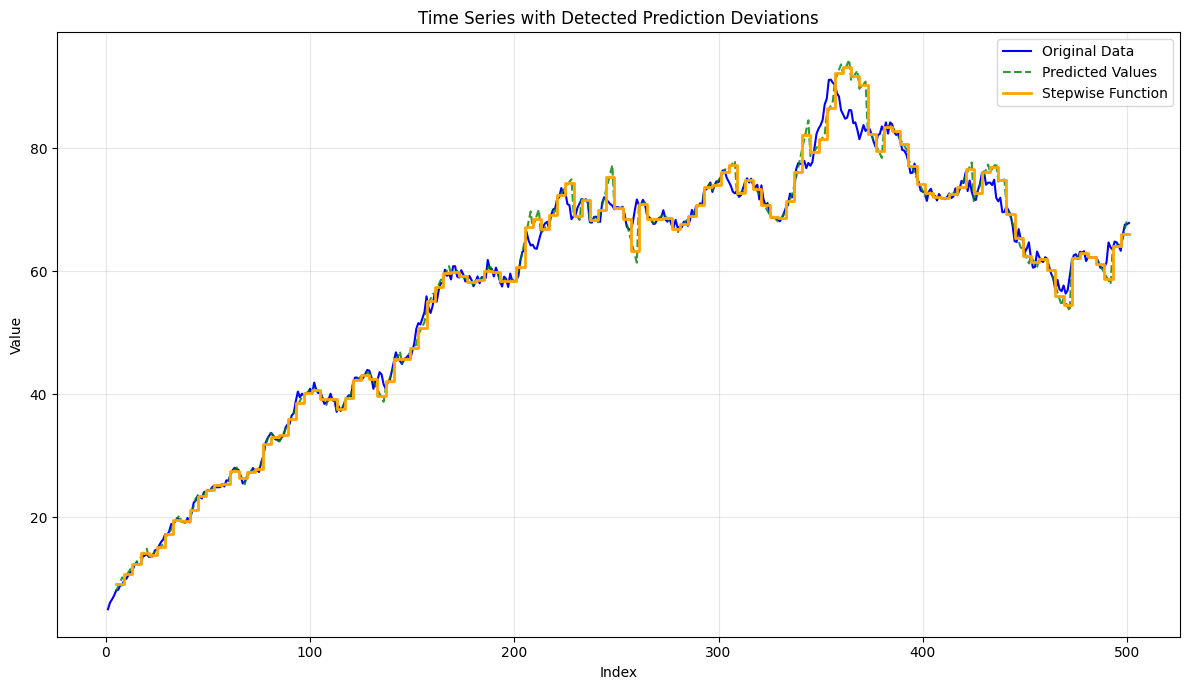

MSE for predicted value 4.279828049595172
MSE for stepwise value 4.250120546743512
KL divergence 2.6422723561212766
   time     value
0  0.00  5.000000
1  0.02  6.070890
2  0.04  6.610556
3  0.06  7.217665
4  0.08  8.034778
initial_value_5_samples_500ws10


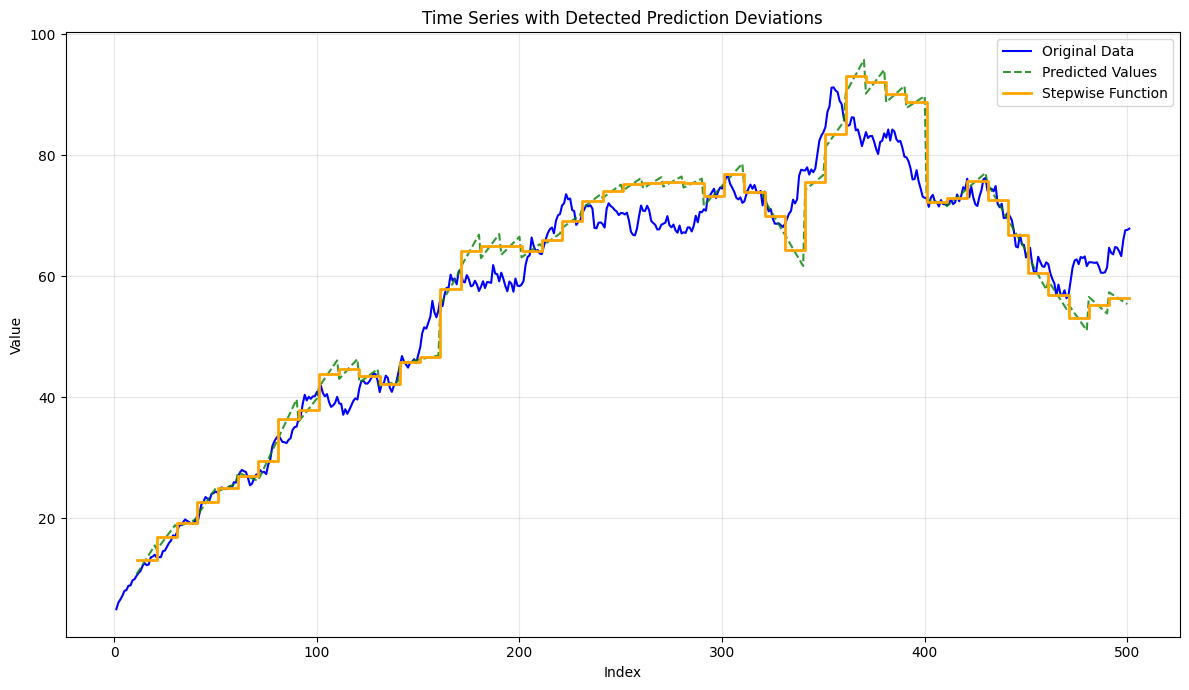

MSE for predicted value 25.271576350348276
MSE for stepwise value 24.76174197654796
KL divergence 6.971914912326015


In [ ]:
save_path = '/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection/data_integrated/result_data/M=500'
mu_5 = 1/10 # expected inter-arrival time for Z0=5
mu_80 = 1/100 # expected inter-arrival time for Z0=80
time_step = 0.02 # time step for the simulation
window_sizes = {
    5: [int(mu_5 * x / time_step) for x in [2/5, 3/5, 4/5, 2]],
    80: [int(mu_80 * x / time_step) for x in [4,6,8,20]]
}
path = '/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection/data_integrated/arrival_data'
files = [f for f in os.listdir(path) ]

for file in files:
    if  'initial_value_5' in file and 'samples_500.csv' in file:
        for window_size in window_sizes[5]:
            data = pd.read_csv(os.path.join(path, file))
            print(data.head())
            file_name = file[:-4]+'ws'+str(window_size)
            print(file_name)
            result_df, deviation_points, MSE = prediction_deviation_analysis(data, window_size=int(window_size))
            result_df.to_csv(os.path.join(save_path, f'results_{file_name}.csv'), index=False)


    if  'initial_value_80' in file and 'samples_500.csv' in file:
        for window_size in window_sizes[80]:
            data = pd.read_csv(os.path.join(path, file))
            print(data.head())
            file_name = file[:-4]+'ws'+str(window_size)
            print(file_name)
            result_df, deviation_points, MSE = prediction_deviation_analysis(data, window_size=int(window_size))
            result_df.to_csv(os.path.join(save_path, f'results_{file_name}.csv'), index=False)
        


In [5]:
save_path = '/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection/data_integrated/result_data'
window_sizes = []
path = '/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection/data_integrated/data'
files = [f for f in os.listdir(path) if f.startswith('initial_value_')]
for window_size in window_sizes:
    for file in files:
        data = pd.read_csv(os.path.join(path, file))
        print(data.head())
        file_name = file[:-4]+'ws'+str(window_size)
        print(file_name)
        result_df, deviation_points, MSE = prediction_deviation_analysis(data, window_size=window_size)
        result_df.to_csv(os.path.join(save_path, f'results_{file_name}.csv'), index=False)



FileNotFoundError: [Errno 2] No such file or directory: '/Users/qianxinhui/Desktop/NU-Research/kellogg/change-point-detection/data_integrated/data'